In [1]:
import os, sys

def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path

proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

import pandas as pd
import yaml
import torch
import collections

import warnings
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

warnings.filterwarnings("ignore")

from dqn.opinion_dynamics.utils.experiment import process_experiment


C:\Users\Chainsword\AppData\Local\Temp\ipykernel_27992\2700633988.py:12: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# experiment_sub_dir = "2025May02-101004_configs" # excellent run
experiment_sub_dir = "2025May15-000132_configs"

exp_path = os.path.join(r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results", experiment_sub_dir)
df = process_experiment(
    exp_path
)
df.columns


Index(['epoch_type', 'frame_stamp', 'greedy_epsilon', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_agent_params.args_.action_w_noise_amplitude',
       'sub_exp_cfg_experiment_run_name', 'sub_experiment_path', 'seed',
       'experiment_name'],
      dtype='

In [3]:
df

,epoch_type,frame_stamp,greedy_epsilon,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,...,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,sub_exp_cfg_experiment_run_name,sub_experiment_path,seed,experiment_name
0,training,200000,0.9571,-12794.711927,-5.101987,-14.449954,-7.476635,146.358996,-6261.036054,-3.717650,...,0.157203,0.041949,48749.0,48.0,0 days 00:04:30.419292,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
1,training,400000,0.9131,-2407.437573,-5.230071,-11.538669,-7.413083,35.500605,-2405.698947,-3.796952,...,0.259462,0.033372,50000.0,48.0,0 days 00:04:56.898910,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
2,training,600000,0.8691,-16311.572107,-5.253712,-14.896672,-7.347484,196.006642,-14679.112093,-3.753167,...,0.348280,0.048194,50000.0,52.0,0 days 00:05:11.289726,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
3,training,800000,0.8251,-81435.327835,-5.141499,-19.356220,-7.301740,726.927205,-25558.014841,-3.697148,...,0.453471,0.058538,50000.0,48.0,0 days 00:05:07.762349,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
4,training,1000000,0.7811,-6338.762346,-5.304350,-12.129339,-7.224180,80.243145,-4363.982349,-3.773134,...,0.530237,0.065589,50000.0,52.0,0 days 00:06:00.448436,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,validation,5200000,NaN,-9.586835,-9.578817,-9.583337,-9.583477,0.001476,-5.093721,-5.090901,...,-1.139930,9.058579,NaN,NaN,0 days 00:00:00.563684,0.8,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,4,0001_agent_params.args_.action_w_noise_amplitu...
596,validation,5400000,NaN,-9.757960,-9.753363,-9.755768,-9.755829,0.001465,-5.142443,-5.140784,...,-1.205826,2.886188,NaN,NaN,0 days 00:00:00.583504,0.8,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,4,0001_agent_params.args_.action_w_noise_amplitu...
597,validation,5600000,NaN,-10.401149,-10.395211,-10.398272,-10.398302,0.001613,-5.254223,-5.252383,...,-1.463918,3.229685,NaN,NaN,0 days 00:00:00.568415,0.8,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,4,0001_agent_params.args_.action_w_noise_amplitu...
598,validation,5800000,NaN,-10.456859,-10.448226,-10.453213,-10.453237,0.001917,-5.252506,-5.249899,...,-1.583897,1.250963,NaN,NaN,0 days 00:00:00.540569,0.8,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,4,0001_agent_params.args_.action_w_noise_amplitu...


In [4]:
df[df['epoch_type'] == 'validation']

,epoch_type,frame_stamp,greedy_epsilon,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,...,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,sub_exp_cfg_experiment_run_name,sub_experiment_path,seed,experiment_name
30,validation,200000,NaN,-8.857231,-8.852881,-8.854820,-8.854756,0.001134,-4.774449,-4.773068,...,0.220845,0.017126,NaN,NaN,0 days 00:00:00.730326,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
31,validation,400000,NaN,-8.784141,-8.779631,-8.781392,-8.781327,0.000844,-4.758798,-4.757618,...,0.310646,0.028280,NaN,NaN,0 days 00:00:00.681290,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
32,validation,600000,NaN,-8.635195,-8.631834,-8.633469,-8.633392,0.000762,-4.738327,-4.737345,...,0.414419,0.043047,NaN,NaN,0 days 00:00:00.643673,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
33,validation,800000,NaN,-8.592041,-8.588427,-8.590191,-8.590300,0.000783,-4.728863,-4.727701,...,0.506545,0.057765,NaN,NaN,0 days 00:00:00.685854,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
34,validation,1000000,NaN,-8.563705,-8.560802,-8.562064,-8.562027,0.000715,-4.722614,-4.721662,...,0.563839,0.065475,NaN,NaN,0 days 00:00:00.794242,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,validation,5200000,NaN,-9.586835,-9.578817,-9.583337,-9.583477,0.001476,-5.093721,-5.090901,...,-1.139930,9.058579,NaN,NaN,0 days 00:00:00.563684,0.8,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,4,0001_agent_params.args_.action_w_noise_amplitu...
596,validation,5400000,NaN,-9.757960,-9.753363,-9.755768,-9.755829,0.001465,-5.142443,-5.140784,...,-1.205826,2.886188,NaN,NaN,0 days 00:00:00.583504,0.8,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,4,0001_agent_params.args_.action_w_noise_amplitu...
597,validation,5600000,NaN,-10.401149,-10.395211,-10.398272,-10.398302,0.001613,-5.254223,-5.252383,...,-1.463918,3.229685,NaN,NaN,0 days 00:00:00.568415,0.8,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,4,0001_agent_params.args_.action_w_noise_amplitu...
598,validation,5800000,NaN,-10.456859,-10.448226,-10.453213,-10.453237,0.001917,-5.252506,-5.249899,...,-1.583897,1.250963,NaN,NaN,0 days 00:00:00.540569,0.8,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,4,0001_agent_params.args_.action_w_noise_amplitu...


In [5]:
# Define hyperparameter columns
hyperparam_columns = [col for col in df.columns if "sub_exp_cfg" in col]

# Group by hyperparameter values and compute mean episode_rewards_mean
averaged_results = df.groupby(hyperparam_columns, as_index=False).agg({
    'episode_rewards_mean': 'mean',  # Averaging the performance metric
    'sub_experiment_path': 'first'   # Keep a reference to an experiment path
})

# Find the best hyperparameter set based on the highest mean reward
best_row = averaged_results.loc[averaged_results['episode_rewards_mean'].idxmax()]

# Print the best experiment path and hyperparameters
print(f"Best hyperparameters:\n{best_row[hyperparam_columns]}")
print(f"Best mean reward: {best_row['episode_rewards_mean']}")

Best hyperparameters:
sub_exp_cfg_agent_params.args_.action_w_noise_amplitude            0.3
sub_exp_cfg_experiment_run_name                            best_params
Name: 0, dtype: object
Best mean reward: -9.523607309626852


In [6]:
averaged_results

,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,sub_exp_cfg_experiment_run_name,episode_rewards_mean,sub_experiment_path
0,0.3,best_params,-9.523607,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
1,0.8,best_params,-10.967872,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...


In [7]:
# selected_metric = 'episode_rewards_mean'
# hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"

# # Filter for validation episodes
# validation_df = df[df['epoch_type'] == 'validation']

# # Get the unique sorted frame_stamp values
# unique_frames = np.sort(validation_df['frame_stamp'].unique())
# N = 1
# # Get all frame_stamp values after the first N unique ones
# filtered_frames = unique_frames[N:]

# # Filter the DataFrame to only include rows with these frame_stamp values
# filtered_df = validation_df[validation_df['frame_stamp'].isin(filtered_frames)]

# plt.figure(figsize=(10, 6))
# sns.lineplot(data=filtered_df, x='frame_stamp', y=selected_metric, hue=hue_col)
# plt.ylabel(selected_metric)
# plt.xlabel('Frame Stamp')
# plt.show()

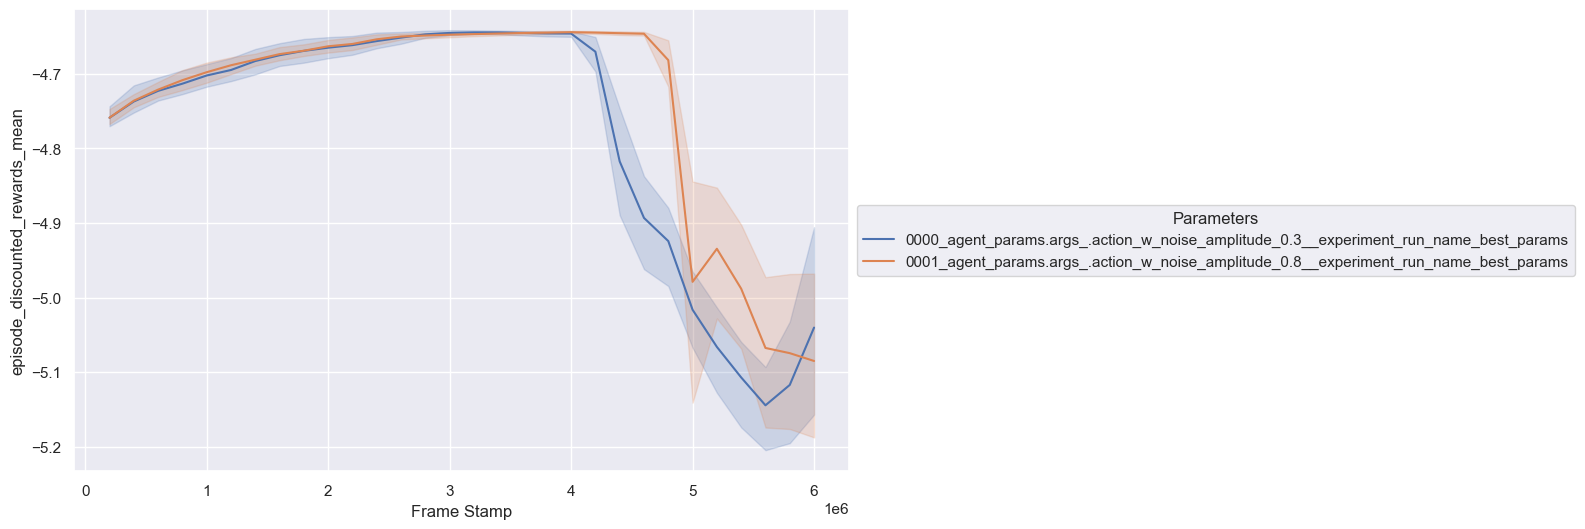

In [8]:

selected_metric = 'episode_discounted_rewards_mean'
# hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"
hue_col = "experiment_name"

validation_df = df[df['epoch_type'] == 'validation']


# Create a new figure for each environment
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='frame_stamp', y=selected_metric, hue='model')
sns.lineplot(data=validation_df, x='frame_stamp', y=selected_metric, hue=hue_col)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')

# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
plt.show()

In [9]:
df.columns

Index(['epoch_type', 'frame_stamp', 'greedy_epsilon', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_agent_params.args_.action_w_noise_amplitude',
       'sub_exp_cfg_experiment_run_name', 'sub_experiment_path', 'seed',
       'experiment_name'],
      dtype='

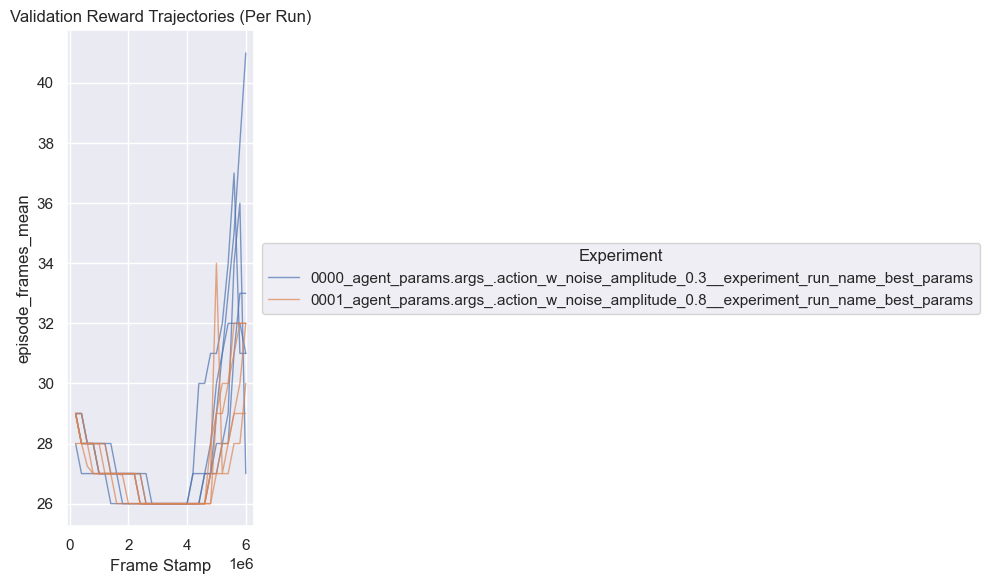

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_metric = 'episode_frames_mean'
hue_col = "experiment_name"  # or another distinguishing column like "sub_experiment_path"

validation_df = df[df['epoch_type'] == 'validation']

# Plot individual lines for each run
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=validation_df,
    x='frame_stamp',
    y=selected_metric,
    hue=hue_col,
    estimator=None,  # ← disables aggregation
    units='sub_experiment_path',  # ← groups lines by unique run
    lw=1,  # line width
    alpha=0.7  # transparency
)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.title('Validation Reward Trajectories (Per Run)')

# Move legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Experiment')
plt.tight_layout()
plt.show()


In [11]:
### Select data

experiment_columns = [
    'epoch_type', 'frame_stamp',
    'episode_rewards_mean', 'episode_frames_mean', 
    'episode_discounted_rewards_mean',
    'policy_trained_times', 'target_trained_times', 'epoch_time', 
       'seed', 'experiment_name', "sub_experiment_path"
]
hyperparam_columns = [
   col for col in df.columns if "sub_exp_cfg" in col
]

cols_of_interest = experiment_columns + hyperparam_columns

sub_df = df[cols_of_interest]
sub_df = sub_df[sub_df['epoch_type'] == 'validation']
sub_df = sub_df[sub_df['frame_stamp'] == sub_df['frame_stamp'].max()]

sub_df 


,epoch_type,frame_stamp,episode_rewards_mean,episode_frames_mean,episode_discounted_rewards_mean,policy_trained_times,target_trained_times,epoch_time,seed,experiment_name,sub_experiment_path,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,sub_exp_cfg_experiment_run_name
59,validation,6000000,-10.254692,33.0,-5.129414,NaN,NaN,0 days 00:00:00.517144,0,0000_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.3,best_params
119,validation,6000000,-8.551891,27.0,-4.792265,NaN,NaN,0 days 00:00:00.581745,1,0000_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.3,best_params
179,validation,6000000,-9.754341,31.0,-5.046114,NaN,NaN,0 days 00:00:00.576494,2,0000_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.3,best_params
239,validation,6000000,-11.625494,41.0,-5.210731,NaN,NaN,0 days 00:00:00.600058,3,0000_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.3,best_params
299,validation,6000000,-9.682139,31.0,-5.023045,NaN,NaN,0 days 00:00:00.607255,4,0000_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.3,best_params
359,validation,6000000,-9.793698,30.0,-5.085707,NaN,NaN,0 days 00:00:00.553144,0,0001_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.8,best_params
419,validation,6000000,-10.323217,32.0,-5.164117,NaN,NaN,0 days 00:00:00.490249,1,0001_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.8,best_params
479,validation,6000000,-8.958045,29.0,-4.866389,NaN,NaN,0 days 00:00:00.519287,2,0001_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.8,best_params
539,validation,6000000,-9.963467,32.0,-5.076877,NaN,NaN,0 days 00:00:00.503419,3,0001_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.8,best_params
599,validation,6000000,-10.435231,32.0,-5.232038,NaN,NaN,0 days 00:00:00.482961,4,0001_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.8,best_params


In [12]:
# agg_cols = [col for col in sub_df.columns if "sub_exp_cfg_agent_params" in col]
# aggregated_df = (
#     sub_df.groupby(agg_cols)
#     .agg(episode_discounted_rewards_mean=("episode_discounted_rewards_mean", "mean"))
#     .reset_index()
# )
# aggregated_df

In [13]:
sub_df.columns

Index(['epoch_type', 'frame_stamp', 'episode_rewards_mean',
       'episode_frames_mean', 'episode_discounted_rewards_mean',
       'policy_trained_times', 'target_trained_times', 'epoch_time', 'seed',
       'experiment_name', 'sub_experiment_path',
       'sub_exp_cfg_agent_params.args_.action_w_noise_amplitude',
       'sub_exp_cfg_experiment_run_name'],
      dtype='object')

In [14]:
# sub_df[[
#     "episode_discounted_rewards_mean", "episode_frames_mean",
#     "seed", "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"]
# ]

In [15]:
# sub_df[
#     (sub_df["sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"] == "0.3") 
# ]

In [16]:
# Print the experiment_name of the row with the highest episode_rewards_mean 
print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['sub_experiment_path'].values[0])
# print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['experiment_name'].values[0])
# print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['episode_rewards_mean'].values[0])


D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025May15-000132_configs\0000_agent_params.args_.action_w_noise_amplitude_0.3__experiment_run_name_best_params\1


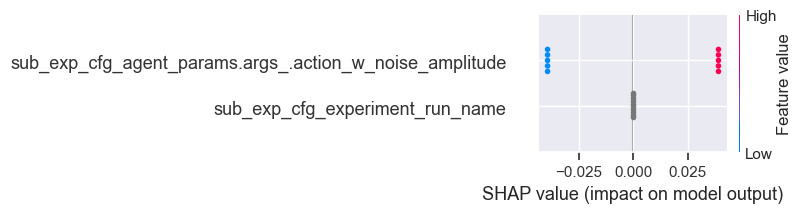

In [17]:
import shap
import xgboost
import pandas as pd


# Define the target metric and hyperparameter columns
target_metric = "episode_rewards_mean"  # Replace with actual metric column name
# Replace with actual hyperparameter column names

# Prepare data
X = sub_df[hyperparam_columns].apply(pd.to_numeric, errors='coerce')
y = sub_df[target_metric].fillna(3 * sub_df[target_metric].min())

# Train an XGBoost model to analyze feature importance
model = xgboost.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, y)

# SHAP analysis
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Summary plot (feature importance)
shap.summary_plot(shap_values, X)

In [18]:
hyperparam_columns

['sub_exp_cfg_agent_params.args_.action_w_noise_amplitude',
 'sub_exp_cfg_experiment_run_name']

In [19]:
import plotly.express as px

# Define readable names for selected hyperparams
readable_names = {
    hyperparam_columns[0]: "noise",
    hyperparam_columns[1]: "size"
}

# Rename columns in a copy of the dataframe
plot_df = sub_df.rename(columns=readable_names)

# Assign new column names
x_col = "noise"
y_col = "episode_rewards_mean"
facet_col = "size"

# Plot
fig = px.scatter(
    plot_df,
    x=x_col,
    y=y_col,
    color="experiment_name",  # Optional: color by experiment
    facet_col=facet_col,
    title="Episode Rewards vs. Noise Faceted by Size",
    height=600
)

fig.update_layout(showlegend=False)
fig.show()
